<a href="https://colab.research.google.com/github/dmika1234/dl_uwr/blob/develop/Assignments/Assignment3/colab_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, settings

In [1]:
%pylab inline
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Torch has to go first due to an importing bug
import collections
import logging
import os
import re

import httpimport
import numpy as np
import PIL
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.autograd import Variable
# import torch.utils.data as data

logging.getLogger("PIL").setLevel(logging.INFO)

# Colab
# %load_ext autoreload
# %autoreload
with httpimport.github_repo(
     "dmika1234", "dl_uwr", "develop"
):
     from Assignments.Assignment3.funs import VGG, VGGPreprocess, ILSVRC2014Sample, to_tensor, to_np, obscured_imgs, discrete_cmap, SubsampledImageDataset, compute_error_rate, plot_history, train, FilterVisualizer, change_axis_tonp, change_axis_totensor, DeepDreamViz, FGSM_Attack
with httpimport.github_repo(
    "janchorowski", "nn_assignments", "nn18"
):
    import common.plotting

In [3]:
# On GPU enabled devices set device='cuda' else set device='cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CUDA = device.type == 'cuda'
CUDA

True

In [4]:
![ -e ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ilsvrc_subsample.tar.bz2
![ -d ilsvrc_subsample ] || tar jxf ilsvrc_subsample.tar.bz2

Downloading...
From: https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC
To: /content/ilsvrc_subsample.tar.bz2
100% 25.5M/25.5M [00:01<00:00, 18.7MB/s]


# Loading VGG model

In [5]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 157MB/s]


In [6]:
# List layers in the model
print("Feature layers")
print("--------------")
for name, layer in zip(vgg.feature_names, vgg.features):
    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

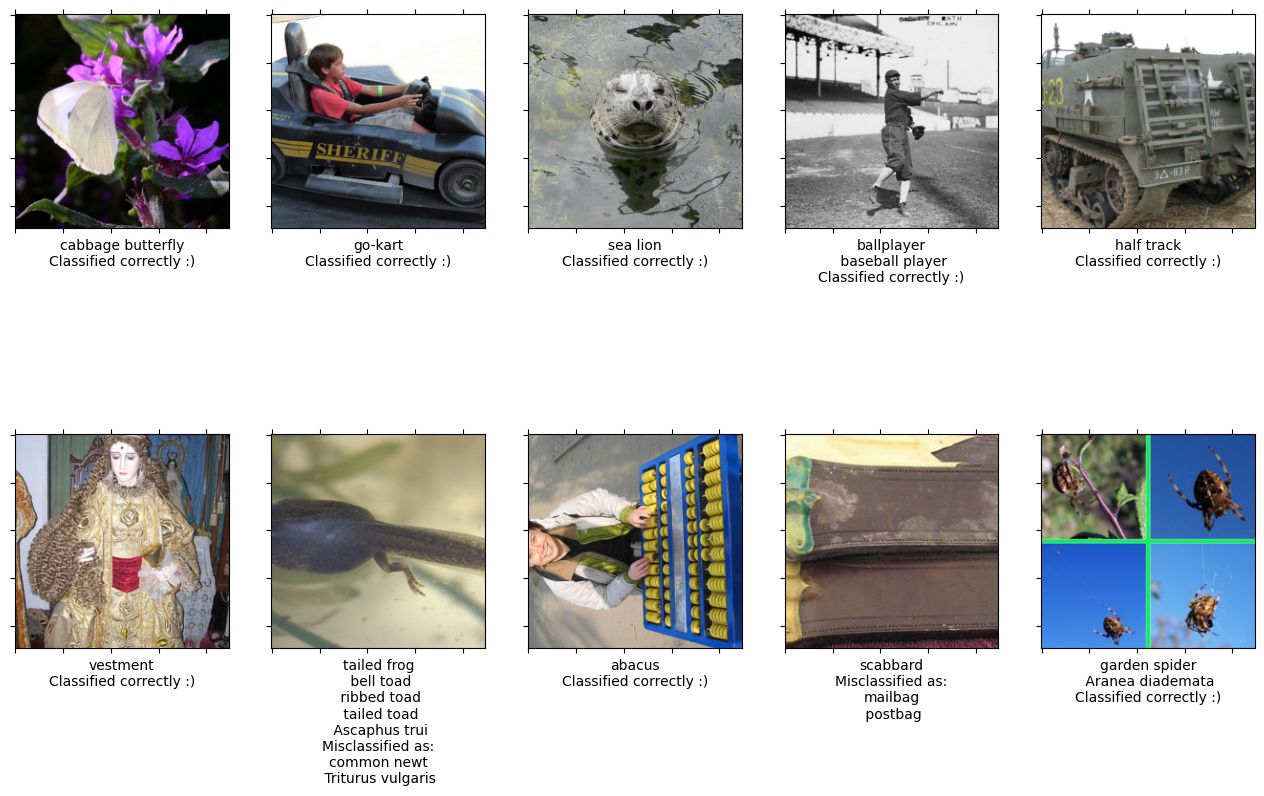

In [7]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

figsize(16, 10)
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_tensor(img, cuda=CUDA)

    predicted_label_id = to_np(vgg.predict(img_torch)).reshape(-1)[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]

    desc = ilsvrc.label_to_desc[label].split(",")
    if label == predicted_label:
        desc.append("Classified correctly :)")
    else:
        desc.append("Misclassified as:")
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(","))

    ax = plt.subplot(2, 5, 1 + i)
    ax.set_xlabel("\n".join(desc))  # , {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
    ax.grid(False)
    plt.imshow(img)

# Problem 1

## 1.1 Implement classification of your own images below

In [ ]:
!gdown https://drive.google.com/drive/folders/1cTPDKYU331ymzyZr5JKOjfTULK53S-mi?usp=sharing --folder

Retrieving folder list
Processing file 1QpkvaWHQL5IsuaxT1TtAcdVsjIQU_f_9 dogfrog.jpg
Processing file 1ns-qDg6btjTe-0pr2qBOOSRwccYcCzhc kwiot.jpg
Processing file 16YW66EGLPBcAydbc4CTSr-jg6i1zAiJZ photo_1.jpg
Processing file 1j-iiMgB_ljuVNhjqhVE7AgPpz1h6MXX9 pigeonman.jpg
Processing file 1yA_Zihof_kUG297jQxNmg6a5sJ8NOuaY suzi.jpg
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1QpkvaWHQL5IsuaxT1TtAcdVsjIQU_f_9
To: /content/Sample_img/dogfrog.jpg
100% 56.5k/56.5k [00:00<00:00, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ns-qDg6btjTe-0pr2qBOOSRwccYcCzhc
To: /content/Sample_img/kwiot.jpg
100% 923k/923k [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=16YW66EGLPBcAydbc4CTSr-jg6i1zAiJZ
To: /content/Sample_img/photo_1.jpg
100% 56.9k/56.9k [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j-iiMgB_ljuVNhjqhVE7AgPpz1h6MXX9


In [ ]:
sample_img_dir = 'Sample_img/'
sample_imgs = [f for f in os.listdir(sample_img_dir)]

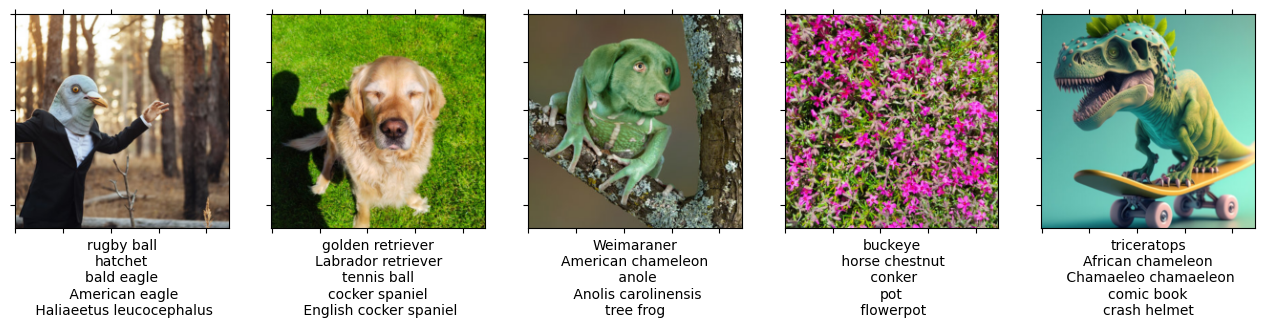

In [ ]:
figsize(16, 10)
i = 0
for sample_img in sample_imgs:
  img = ilsvrc.load_image(sample_img_dir + sample_img)
  img_torch = to_tensor(img, cuda=CUDA)

  predicted_label_id = to_np(vgg.predict(img_torch, k=5)).reshape(-1)
  predicted_labels = []
  for id in predicted_label_id:
    predicted_label = ilsvrc.id_to_label[id]
    predicted_labels.extend(ilsvrc.label_to_desc[predicted_label].split(","))
  predicted_labels = predicted_labels[0:5]

  ax = plt.subplot(2, 5, 1 + i)
  ax.set_xlabel("\n".join(predicted_labels))  # , {'verticalalignment': 'bottom'})
  ax.set_xticklabels([], visible=False)
  ax.set_yticklabels([], visible=False)
  ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
  ax.grid(False)
  plt.imshow(img)
  i += 1

In [ ]:
ilsvrc.label_to_desc[predicted_label].split(",")[0]

'monitor'

## 1.2 Analyse the responses of the network when part of the input is obscured

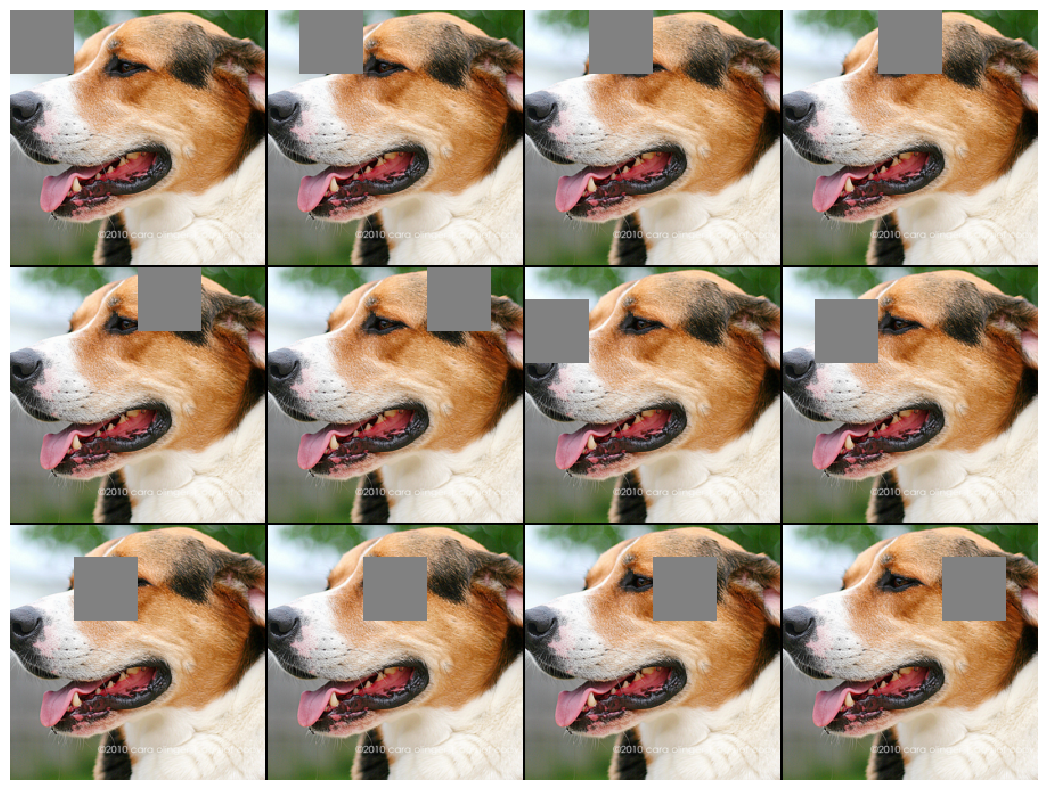

In [ ]:
# Show samples from an obscured batch
batch = next(obscured_imgs(ilsvrc.data[27], boxsize=56, bsz=12, stride=28))
batch = np.vstack([im[None] for im in batch])

common.plotting.plot_mat(batch.transpose(0, 3, 1, 2))

In [ ]:
idx = 32
img = ilsvrc.data[idx]
label = ilsvrc.labels[idx]

# if you run out of GPU mem split batch into smaller ones
bsz = 64
boxsize = 52
stride = 14

vgg.eval()

# Accumulate activations for activation heatmap,
# true class probability map, network prediction map
map_types = ["heat", "prob", "pred"]
maps = {mt: [] for mt in map_types}
for batch in obscured_imgs(img, boxsize, bsz, stride):
    with torch.no_grad():
        batch = to_tensor(np.array(batch), cuda=CUDA)
        # TODO choose a layer and a neuron. Aggregate its activations across all locations in the image
        # The sample code used layer conv2_1 and neuron #1
        maps["heat"].append(to_np(vgg.layer_activations(batch, "conv2_1"))[:, 1].sum(axis=(1, 2)))
        # TODO record the probability assigned to the correct class
        maps["prob"].append(to_np(vgg.probabilities(batch))[:, ilsvrc.label_to_id[label]])
        # TODO record the network predictions
        maps['pred'].append(to_np(vgg.predict(batch)))

for k in maps:
    maps[k] = np.concatenate(maps[k])
    maps[k] = maps[k].reshape(int(np.sqrt(maps[k].shape[0])), -1)

Text(0.5, 1.0, 'The most probable class as a function\nof the obscuring square location')

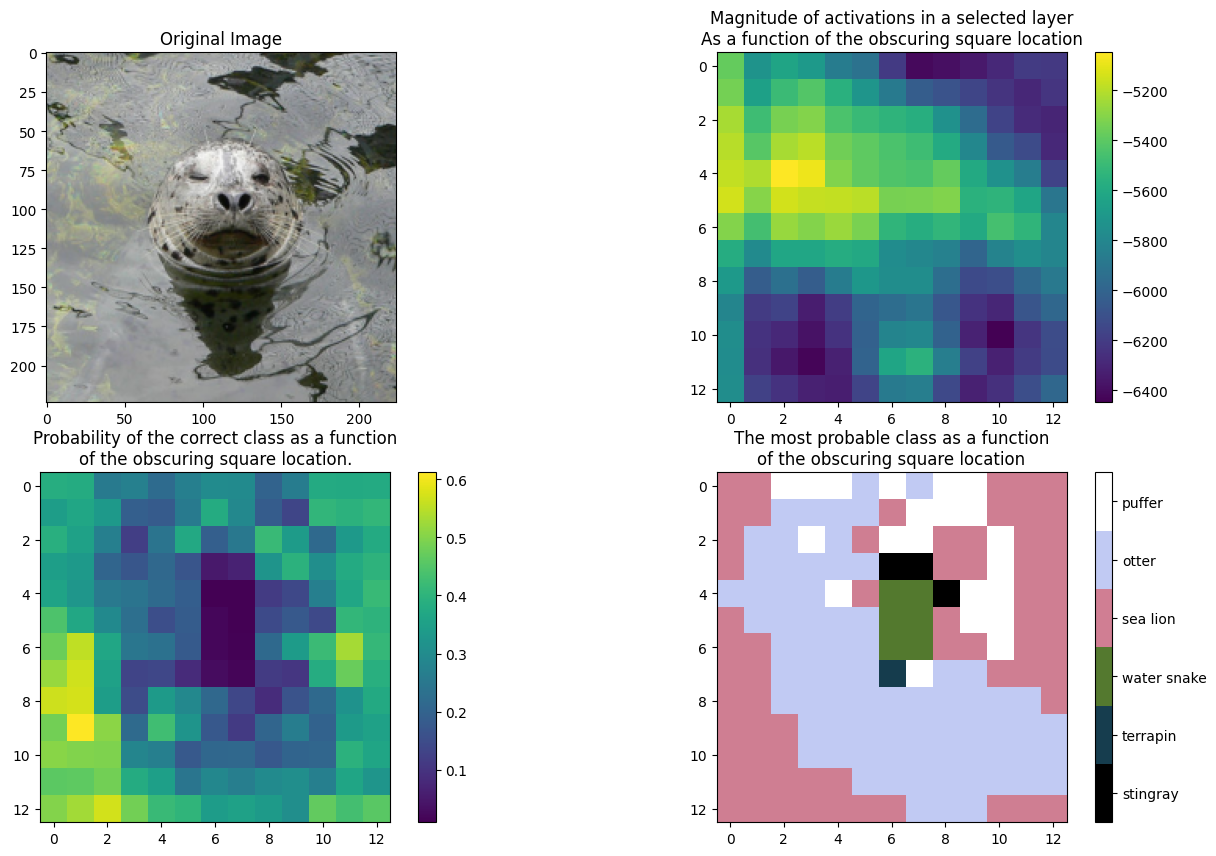

In [ ]:
#
# This image recreates figure 7 from M. Zieler et al.
# Visualizing and Understanding Convolutional Neural Networks
# https://arxiv.org/pdf/1311.2901.pdf
#

plt.figure(figsize(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.grid(False)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(maps["heat"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Magnitude of activations in a selected layer\n"
    "As a function of the obscuring square location"
)

plt.subplot(2, 2, 3)
plt.imshow(maps["prob"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Probability of the correct class as a function\n"
    "of the obscuring square location."
)

plt.subplot(2, 2, 4)
discrete = np.zeros_like(maps["pred"], dtype=np.int64)
values = np.unique(maps["pred"]).astype(np.int64)
for i, v in enumerate(values):
    discrete[np.where(maps["pred"] == v)] = i
num_values = max(values.shape[0], 1)
plt.imshow(discrete, cmap=discrete_cmap(num_values, "cubehelix"))
plt.grid(False)
cb = plt.colorbar(
    ticks=np.arange(
        (num_values - 1.0) / num_values / 2.0,
        num_values,
        (num_values - 1.0) / num_values,
    )[:-1]
)
cb.set_ticklabels([ilsvrc.id_to_desc[v].split(',')[0] for v in values])
plt.title("The most probable class as a function\n" "of the obscuring square location")

## 1.3 [Integrated Gradients](https://arxiv.org/abs/1703.01365)

In [ ]:
idx = 16
img = ilsvrc.data[idx][None, ...]
label = ilsvrc.labels[idx]

predicted_id = to_np(vgg.predict(to_tensor(img, cuda=CUDA)))[0][0]

print(
    "Predicted: %s (correct: %s)"
    % (ilsvrc.id_to_desc[predicted_id], ilsvrc.label_to_desc[label])
)

num_integration_points = 300

batch_size = 20

assert (num_integration_points % batch_size) == 0

weights = np.linspace(0.0, 1.0, num_integration_points).astype("float32")[
    :, None, None, None
]
grads = []

for i in range(0, num_integration_points, batch_size):
    # TODO: batch contains a subset of images interpolating between the all gray image and the selected image
    batch = weights[i : i + batch_size] * img + (1.0 - weights[i : i + batch_size]) * (
        np.zeros_like(img) + 0.5)
    batch = to_tensor(batch, cuda=CUDA, requires_grad=True)

    # TODO: Get the probabilities for the correct class
    prediction = torch.sum(
        vgg.probabilities(batch)[:, predicted_id])
    # And backpropagate towards the input
    prediction.backward()
    grads.append(to_np(batch.grad))

grads = np.concatenate(grads, axis=0)

# TODO: compute the pixel importance score
importance_scores = np.sum(np.abs(grads), axis=(0,-1)) / grads.shape[0]

Predicted: axolotl, mud puppy, Ambystoma mexicanum (correct: sea anemone, anemone)


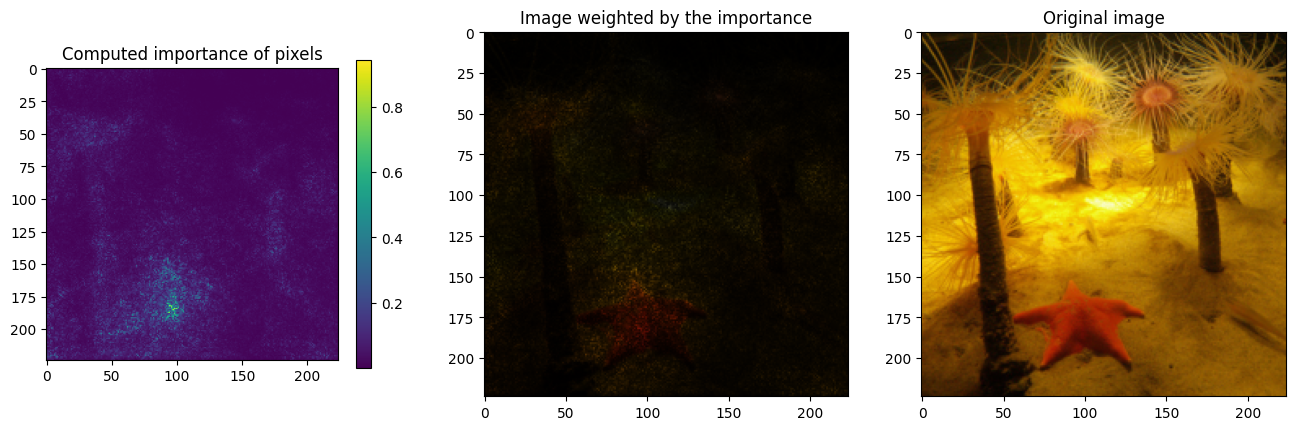

In [ ]:
figsize(16, 10)
plt.subplot(1, 3, 1)
plt.imshow(importance_scores, cmap="viridis")
plt.colorbar(shrink=0.4)
plt.title("Computed importance of pixels")
plt.grid(False)

plt.subplot(1, 3, 2)
# normalize the scores to be <=1
w = importance_scores / importance_scores.max()
w = w ** 0.7  # a little gamma correction may make the image prettier
plt.imshow(img[0] * w[:, :, None])
plt.title("Image weighted by the importance")
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(img[0])
plt.title("Original image")
plt.grid(False)

## 1.4 SHAP pixel importances

https://github.com/marcotcr/lime

https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/Explain%20an%20Intermediate%20Layer%20of%20VGG16%20on%20ImageNet%20%28PyTorch%29.html

In [ ]:
!pip install lime
!pip install shap

In [ ]:
ilsvrc = ILSVRC2014Sample(100)
idx = 16
to_explain = ilsvrc.data[idx][None, ...]
vgg.eval()

### SHAPE


In [ ]:
import shap

In [ ]:
e = shap.GradientExplainer((vgg, vgg.features[7]), to_tensor(np.array(ilsvrc.data), cuda=CUDA))
shap_values, indexes = e.shap_values(to_tensor(to_explain, cuda=CUDA), ranked_outputs=2, nsamples=80)

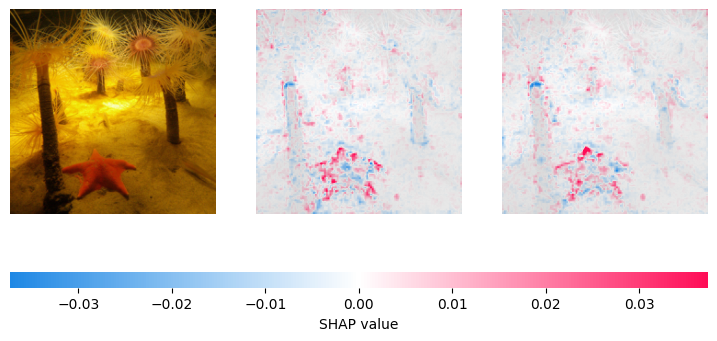

In [ ]:
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain)

### LIME


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import quickshift

In [ ]:
def lime_predict(img):
    vgg.eval()
    CUDA = torch.cuda.is_available()
    prob = vgg.probabilities(to_tensor(np.array(img, dtype=np.float32), cuda=CUDA))
    return to_np(prob)
def segmentation_fn(img):
    segments = quickshift(img, kernel_size=3, max_dist=200, ratio=0.2)
    return segments

In [ ]:
img = np.array(ilsvrc.data[idx], dtype=np.float64)
# img is the input image
segments = quickshift(img, kernel_size=3, max_dist=200, ratio=0.2)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, 
                                         lime_predict,# classification function
                                         top_labels=3,
                                         num_samples=5000) # number of images that will be sent to classification function

  0%|          | 0/5000 [00:00<?, ?it/s]

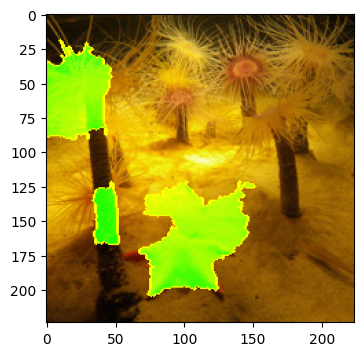

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5)
img_boundry1 = mark_boundaries(temp, mask)
figsize(4, 4)
plt.imshow(img_boundry1)

## 1.5 Comparison of importance attribution methods

## 1.6 Find image patches that activate selected neurons

In [ ]:
num_images = 3
num_patches = 10
layer_name = "conv1_2"
num_neurons = 10
selected_neurons = np.random.choice(num_neurons, size=num_patches)

In [ ]:
# Find the most exciting patches for the selected neurons in each image
exciting_patches = []
for img in ilsvrc.data:
    img_tensor = to_tensor(img, cuda=CUDA)
    layer_activations = vgg.layer_activations(img_tensor, layer_name)
    selected_activations = layer_activations[:, selected_neurons, :, :].reshape(-1, 1)
    _, indices = torch.topk(selected_activations[:,0], k=num_images)
    for idx in indices:
        img_patch = img[idx // layer_activations.shape[2], idx % layer_activations.shape[2]]
        exciting_patches.append(img_patch)


IndexError: ignored

In [ ]:
selected_neurons

array([9, 8, 3])

In [ ]:
# Compute the gradient with respect to the input for the most exciting patches
gradients = []
for patch in exciting_patches:
    patch_tensor = to_tensor(patch[None], requires_grad=True)
    output = vgg.predict(patch_tensor)
    output[0, output.argmax()].backward()
    gradients.append(to_np(patch_tensor.grad)[0])

In [ ]:
# Normalize the gradients to [0, 1] and display the most exciting patches and gradients
for i in range(num_images):
    fig, axs = plt.subplots(1, num_patches+1, figsize=(12, 3))
    for j in range(num_patches):
        axs[j].imshow(exciting_patches[i*num_patches+j])
        axs[j].axis('off')
        axs[j].set_title("Neuron %d" % selected_neurons[j])
    axs[num_patches].imshow(gradients[i])
    axs[num_patches].axis('off')
    axs[num_patches].set_title("Gradient")
    plt.show()

# Problem 2

## Setup

In [ ]:
#![ -d 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
![ -e 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
![ -d 101_ObjectCategories ] || tar zxf 101_ObjectCategories.tar.gz

In [ ]:
caltech_whole_dataset = torchvision.datasets.ImageFolder("./101_ObjectCategories/")

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

In [ ]:
batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=2, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=2, shuffle=False
    ),
}

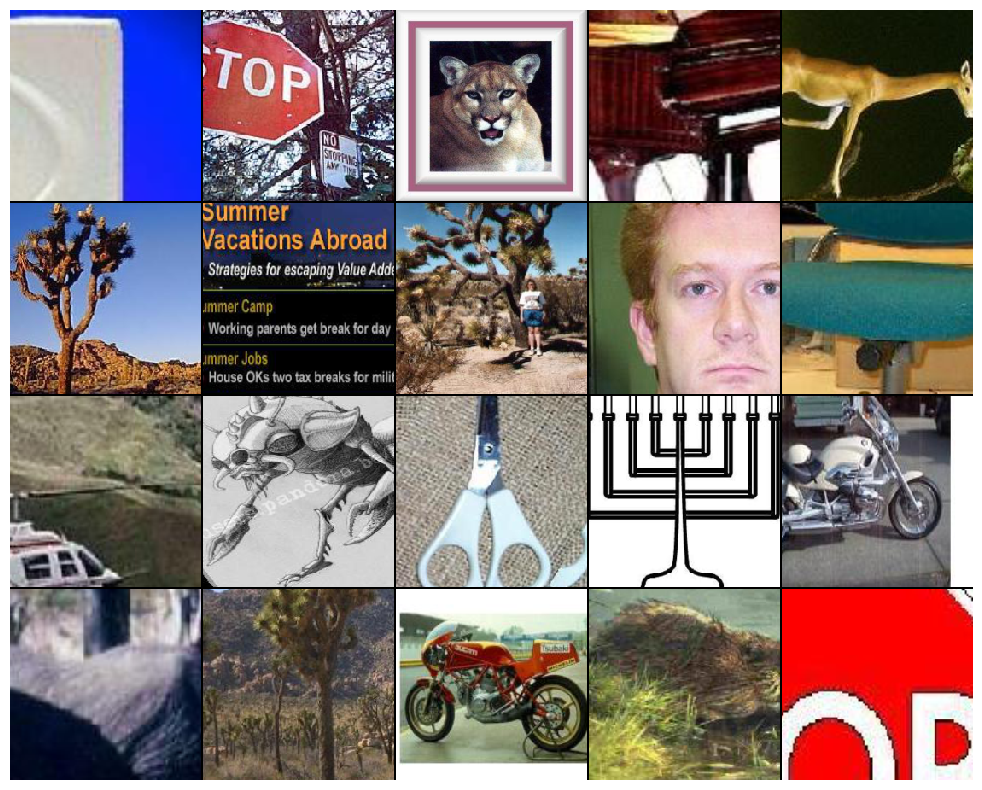

In [ ]:
train_batch = next(iter(caltech_loaders["train"]))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

In [ ]:
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))


Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=1000, bias=True)


In [ ]:
def train(
    model, data_loaders, optimizer, criterion, train_transform=None, num_epochs=1, log_every=100, cuda=True
):
    if cuda:
        model.cuda()

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders["train"]:
                if train_transform:
                    x = train_transform(x)
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1

                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())

                                
                if iter_ % log_every == 0:
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%".format(
                            iter_, loss.item(), err_rate
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["test"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:

                                
                best_epoch = epoch
                best_val_err = val_err_rate

                
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        model.parameters = best_params
    plot_history(history)


# Train only the classifier!
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def plot_history(history):
    figsize(16, 4)
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 20)
    plt.legend()

## Task

### Simple Linear

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  1.65 | err rate 37.50%
Minibatch    100  | loss  1.44 | err rate 31.25%
----------------------------------------------------------
After epoch  1 | valid err rate: 15.91% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  0.93 | err rate 25.00%
Minibatch    200  | loss  0.86 | err rate 21.88%
----------------------------------------------------------
After epoch  2 | valid err rate: 12.63% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  0.71 | err rate 21.88%
Minibatch    300  | loss  0.35 | err rate 10.94%
----------------------------------------------------------
After epoch  3 | valid err rate: 12.74% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.53 | err rate 12.50%
Minibatch    400  | loss  0.68 | err rate 23.44%
Minibatch    450  | los

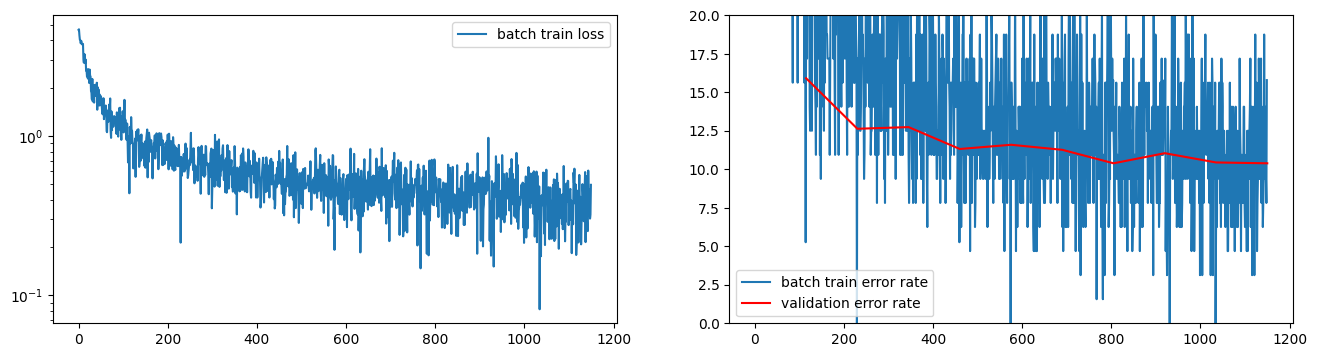

In [ ]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 102))

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)
figsize(16, 4)
train(vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=CUDA)

### Dropout

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  1.81 | err rate 42.19%
Minibatch    100  | loss  0.93 | err rate 18.75%
----------------------------------------------------------
After epoch  1 | valid err rate: 13.83% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  0.68 | err rate 15.62%
Minibatch    200  | loss  0.58 | err rate 14.06%
----------------------------------------------------------
After epoch  2 | valid err rate: 12.90% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  0.71 | err rate 18.75%
Minibatch    300  | loss  0.55 | err rate 14.06%
----------------------------------------------------------
After epoch  3 | valid err rate: 12.30% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  0.38 | err rate 10.94%
Minibatch    400  | loss  0.70 | err rate 15.62%
Minibatch    450  | los

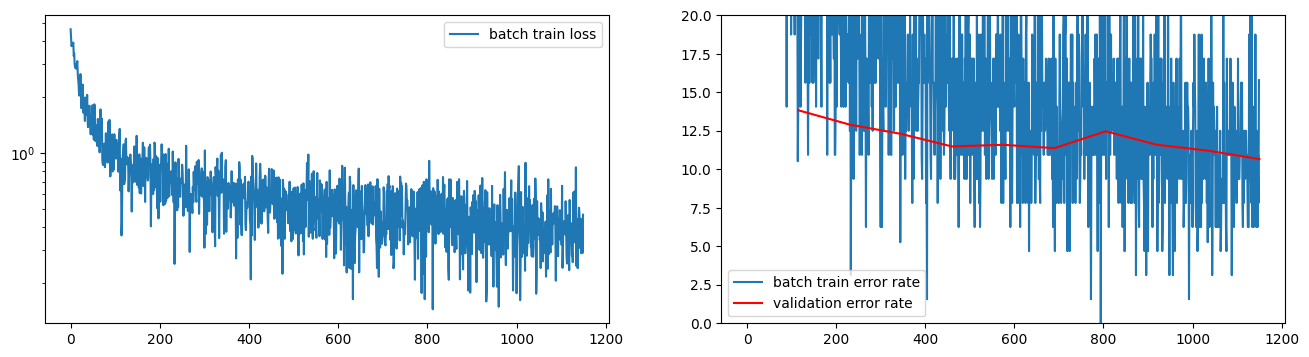

In [ ]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = torch.nn.Sequential(
    torch.nn.Linear(512 * 7 * 7,2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(2048, 102)
)

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)
figsize(16, 4)
train(vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=CUDA)

### Data Augmentation

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  2.57 | err rate 60.94%
Minibatch    100  | loss  1.98 | err rate 48.44%
----------------------------------------------------------
After epoch  1 | valid err rate: 29.20% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  1.34 | err rate 32.81%
Minibatch    200  | loss  2.05 | err rate 51.56%
----------------------------------------------------------
After epoch  2 | valid err rate: 22.25% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  1.57 | err rate 35.94%
Minibatch    300  | loss  1.67 | err rate 39.06%
----------------------------------------------------------
After epoch  3 | valid err rate: 21.43% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  2.22 | err rate 59.38%
Minibatch    400  | loss  1.05 | err rate 29.69%
Minibatch    450  | los

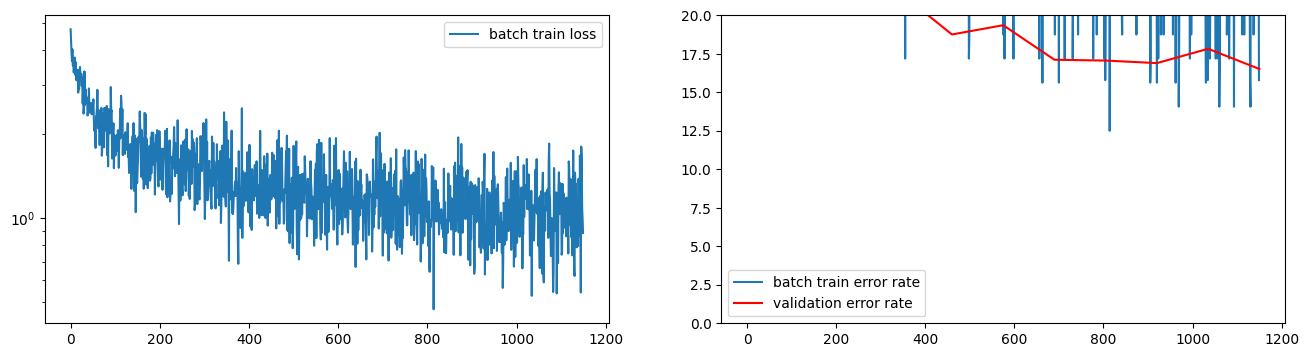

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = torch.nn.Sequential(
    torch.nn.Linear(512 * 7 * 7,2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(2048, 102)
)


# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)
figsize(16, 4)
train(vgg, caltech_loaders, optimizer, criterion, train_transform=train_transform, num_epochs=10, log_every=50, cuda=CUDA)

# Problem 3

## Setup

In [8]:
![ -e images.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF' -O images.tar.bz2
![ -d images ] || tar jxf images.tar.bz2

Downloading...
From: https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF
To: /content/images.tar.bz2
100% 13.5M/13.5M [00:00<00:00, 26.4MB/s]


In [9]:
!ls images

arab_text.jpg	   hoovertowernight.jpg      starry_night_google.jpg
brad_pitt.jpg	   picasso_selfport1907.jpg  starry_night.jpg
crowd.jpg	   pl_text.jpg		     the_scream.jpg
escher_sphere.jpg  seated-nude.jpg	     tubingen.jpg
frida_kahlo.jpg    shipwreck.jpg	     woman-with-hat-matisse.jpg
golden_gate.jpg    starry_night_crop.png     wood.jpeg


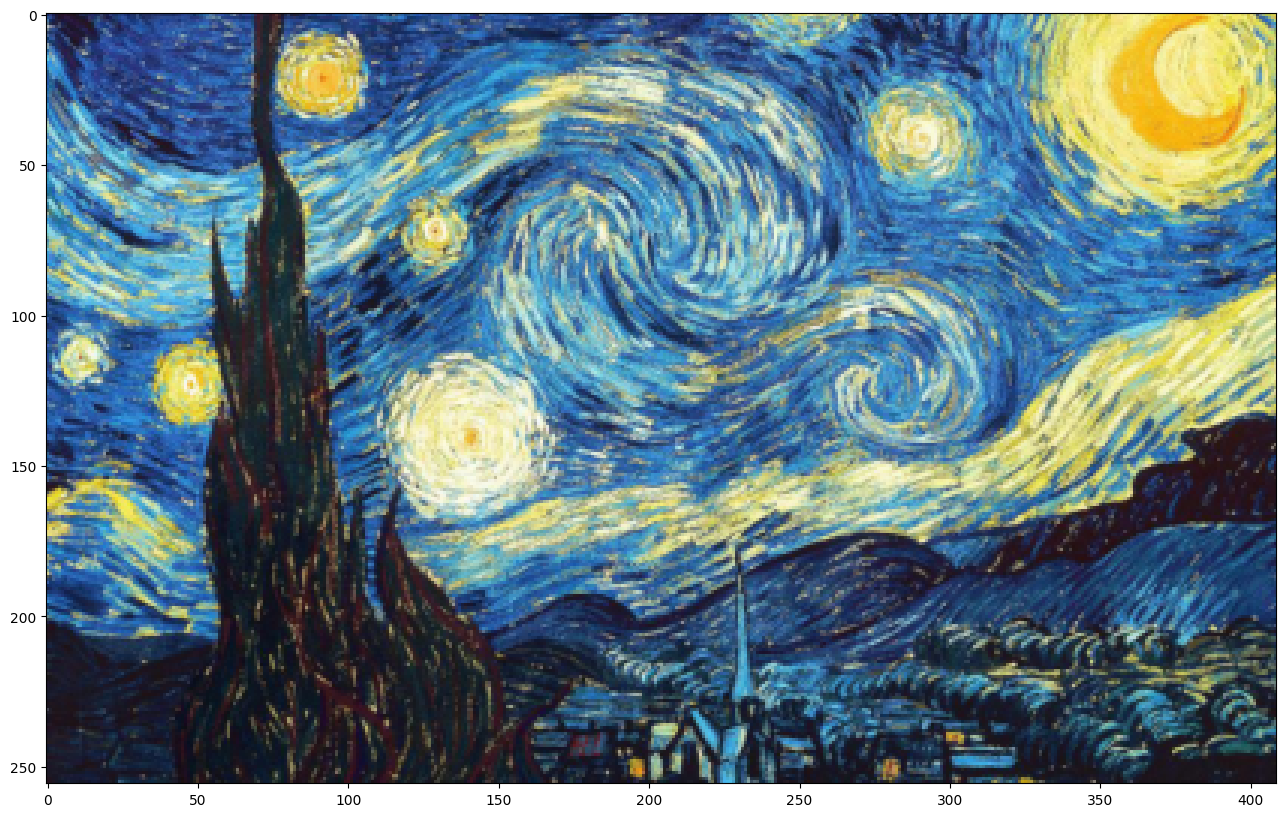

In [10]:
def load_image(path, size=256):
    img = PIL.Image.open(path)
    img = img.convert("RGB")
    img = torchvision.transforms.Resize(size)(img)
    return np.asarray(img).astype("float32") / 255.0


plt.imshow(load_image("images/starry_night.jpg"))
plt.grid(False)

In [11]:
class StyleTransferNet(object):
    def __init__(
        self,
        style_layers,
        content_layers,
        vgg_model="vgg19",
        content_weight=5e0,
        style_weight=1e2,
    ):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()

    def capture_content(self, x):
        # TODO: implement saving naural activations for a chosen set of content layers
        self.content_captures = TODO

    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(x, self.style_layers)
        self.style_captures = [self._gram_mat(l).detach() for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        needed_values = self.vgg.multi_layer_activations(x, needed_layers)
        content_values = needed_values[: len(self.content_layers)]
        style_values = needed_values[len(self.content_layers) :]

        self.content_losses = []
        self.style_losses = []

        # TODO:
        # append onto the lists  self.content_losses and self.style_losses
        # the L2 (euclidean) distances between the captured statistics and the
        # reconstructed image's ones. Remember about applying the gram matrix to style!
        # You can use the self.mse to compute the L2 distance
        
        loss = sum(self.content_losses) * self.content_weight
        loss = loss + sum(self.style_losses) * self.style_weight

        return loss

    def _gram_mat(self, x):
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        # TODO
        # Compute the Gram matrix, as defined in the docstring. Try to implement it as efficiently as possible.
        pass


In [12]:
# TODO find a good set of layers for the content and style images.
# Note: you will have to tune the content weight!
model = StyleTransferNet(
    style_layers=[TODO],
    style_layers=[TODO],
    content_layers=["relu1_1"],
    content_weight=1e2,
content_layers=[TODO], content_weight=10e0)

if CUDA:
    model.vgg.cuda()

SyntaxError: ignored

In [ ]:
# style_img_path = 'images/arab_text.jpg'
style_img_path = "images/starry_night.jpg"
content_img_path = "images/golden_gate.jpg"

style_img_size = 256
content_img_size = 256

style_image = load_image(style_img_path, style_img_size)
content_image = load_image(content_img_path, content_img_size)
content_shape = content_image.shape

print("Capturing content")
model.capture_content(to_tensor(content_image))

print("Capturing style")
model.capture_style(to_tensor(style_image))

In [ ]:
# image = load_image(content_img_path, 512)
image = np.random.randn(*content_shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

# optimizer = torch.optim.Adam([image], lr=0.001)  #, momentum=0.5)
optimizer = torch.optim.LBFGS([image])

In [ ]:
from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = plt.figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    plt.vgrid(False)
    fig.add_subplot(133).imshow(style_image)
    plt.grid(False)
    ax = fig.add_subplot(131)

    plt.tight_layout()
    imsh = ax.imshow(to_np(image))
    plt.grid(False)
    for iter_ in range(max_iters):

        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        # image.data = image.data.clip_(0, 1)

        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)

            print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))
            for i, l in enumerate(model.content_losses):
                print(
                    "  Content loss {}: {: >8.4f}".format(
                        i + 1, l.item() * model.content_weight
                    )
                )
            for i, l in enumerate(model.style_losses):
                print(
                    "  Style loss {}: {: >10.4f}".format(
                        i + 1, l.item() * model.style_weight
                    )
                )

        old_loss = loss.item()
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))

In [ ]:
plt.imshow(np.clip(to_np(image), 0.0, 1.0))
plt.grid(False)

## 3.1

In [237]:
class FilterVisualizer():
    def __init__(self, model, size=64,
                 upscaling_steps=10,
                 upscaling_factor=1.2,
                 blur=1,
                 cuda=True):
        self.size = size
        self.upscaling_steps = upscaling_steps
        self.upscaling_factor = upscaling_factor
        self.model = model
        self.cuda = cuda
        if self.cuda:
            self.model.cuda().eval()
        self.blur = torchvision.transforms.GaussianBlur(blur)
        for param in self.model.parameters():
            param.requires_grad = False

        self.transforms = [
            torchvision.transforms.Resize(256),
            torchvision.transforms.RandomCrop(224)
        ]

    def preprocess(self,x):
        for t in self.transforms:
            x = t(x)
        return x
    
    def scaleup(self, img, sz):
        tensor = torchvision.transforms.Resize((sz, sz))(img)
        tensor = to_tensor(to_np(tensor), requires_grad=True, cuda=self.cuda)
        return tensor
    
    def visualize(self, layer_name, filter, lr=0.01, opt_steps=20):
        if self.cuda:
            self.model.cuda().eval()
        else:
            self.model.eval()
        sz = self.size
        img = np.array(np.random.rand(sz, sz, 3), dtype=np.float32)
        img_tens = to_tensor(change_axis_totensor(img), requires_grad=True, cuda=self.cuda)

        for _ in range(self.upscaling_steps):
            adam = torch.optim.Adam([img_tens], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):
                img_var = self.preprocess(img_tens)
                adam.zero_grad()
                activations = self.model.layer_activations(img_var, layer_name)[0]
                loss = -torch.mean(activations[filter])
                loss.backward()
                adam.step()
            sz = int(self.upscaling_factor * sz)
            img_tens = self.scaleup(self.blur(img_tens), sz)

        self.output = change_axis_tonp(to_np(img_tens))
        self.plot()
    
    def plot(self):
        plt.axis("off")
        plt.imshow(self.output)

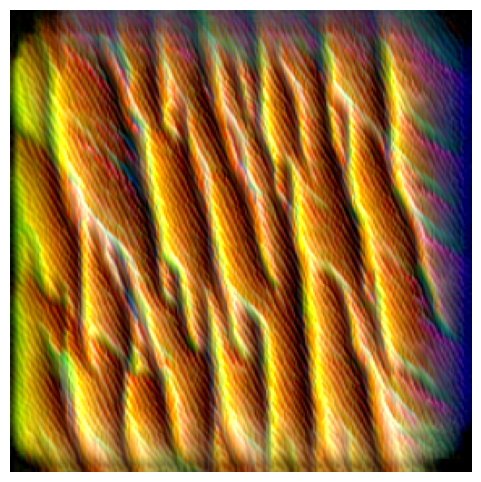

In [242]:
figsize(6, 6)
layer_name = "conv2_2"
filter = 1
FV = FilterVisualizer(vgg, size=48, upscaling_steps=10, upscaling_factor=1.2, blur=5)
FV.visualize(layer_name, filter, opt_steps=35)

## 3.2

In [253]:
class DeepDreamViz():
    def __init__(self, model, size=64,
                 upscaling_factor=1.2,
                 blur=1,
                 cuda=True):
        self.size = size
        self.upscaling_factor = upscaling_factor
        self.model = model
        self.cuda = cuda
        self.blur=torchvision.transforms.GaussianBlur(blur)
        self.transforms = [
            torchvision.transforms.RandomCrop(224)
        ]
        
    def load_image(self, path):
        img = PIL.Image.open(path)
        img = img.convert("RGB")
        return np.asarray(img).astype("float32") / 255.0    
    
    def preprocess(self,x):
        if x.shape[1] < 224:
            x = torchvision.transforms.Resize((224,224))(x)
        for t in self.transforms:
            x = t(x)
        return x

    
    def generate_imgs(self, img, upsc_img_num):
        imgs = [img]
        for _ in range(upsc_img_num - 1):
            new_size = int(imgs[-1].shape[1]*self.upscaling_factor)
            imgs.append(torchvision.transforms.Resize((new_size, new_size))(imgs[-1]))
        return imgs
        
    def visualize(self, path, layer_name, filter, upsc_img_num, lr=0.01, opt_steps=20):
        if self.cuda:
            self.model.cuda().eval()
        else:
            self.model.eval()
        img = self.load_image(path)
        img = to_tensor(change_axis_totensor(img), cuda=self.cuda)
        img = torchvision.transforms.Resize((self.size, self.size))(img)
        imgs = self.generate_imgs(img, upsc_img_num)
        
        change = to_tensor(np.zeros_like(to_np(imgs[-1])), cuda=self.cuda)
        for _, img_tens in enumerate(imgs[::-1]):
            img_tens_cp = to_tensor(to_np(img_tens).copy(), cuda=self.cuda)
            with torch.no_grad():
                img_tens += torchvision.transforms.Resize((img_tens.shape[1:2]))(change)
            img_tens.requires_grad = True
            adam = torch.optim.Adam([img_tens], lr=lr, weight_decay=0)
            for n in range(opt_steps):
                adam.zero_grad()
                img_trans = self.preprocess(img_tens).cuda()
                activations = self.model.layer_activations(img_trans, layer_name)[0]
                loss = -torch.mean(activations[filter])
                loss.backward()
                adam.step()
                with torch.no_grad():
                    torch.clip(self.blur(img_tens),0,1)
            change = img_tens - img_tens_cp
            assert np.any(to_np(change) != 0)
                
        return change_axis_tonp(to_np(img_tens))

In [254]:
DDViz = DeepDreamViz(vgg, upscaling_factor=0.9, size=512, blur=5)

In [256]:
img = DDViz.visualize("/content/images/woman-with-hat-matisse.jpg", layer_name="conv5_3", filter=270, upsc_img_num=15)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


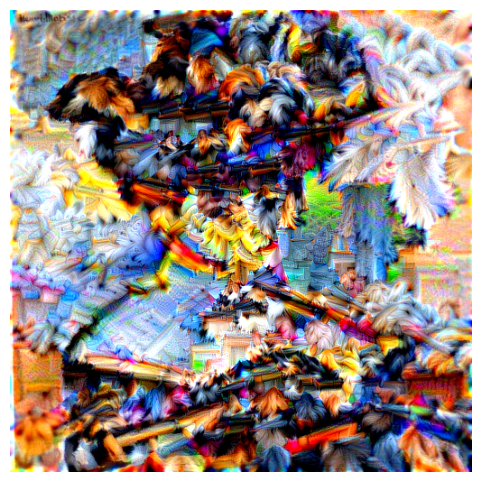

In [257]:
plt.axis("off")
plt.imshow(img)

## 3.3

In [ ]:
class FGSM_Attack:
    def __init__(self, model, epsilon):
        self.model = model
        self.epsilon = epsilon
    
    def generate(self, img, target_class, patch_loc=(0, 0), patch_size=(224, 224)):
        if self.cuda:
            self.model.cuda().eval()
        else:
            self.model.eval()
        # Convert the image to a tensor
        img = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2)
        
        # Create a tensor for the adversarial patch
        patch = torch.zeros_like(img)
        patch[:, :, patch_loc[0]:patch_loc[0] + patch_size[0], patch_loc[1]:patch_loc[1] + patch_size[1]] = 1
        
        # Calculate the gradient of the loss w.r.t. the input image
        img.requires_grad = True
        output = self.model(img)
        loss = -output[0, target_class]
        loss.backward()
        
        # Add the signed gradient of the loss w.r.t. the input image to the patch
        patch_sign = patch.grad.sign()
        patch = patch + self.epsilon * patch_sign
        
        # Clip the adversarial patch to the range [0, 1]
        patch = torch.clamp(patch, 0, 1)
        
        # Apply the adversarial patch to the original image
        img_adv = img + patch
        img_adv = torch.clamp(img_adv, 0, 1)
        
        # Convert the adversarial image to a numpy array
        img_adv = img_adv.squeeze().permute(1, 2, 0).detach().numpy()
        return img_adv
